In [1]:
import numpy as np    # Numeric and matrix computation
import pandas as pd   # Optional: good package for manipulating data 
import sklearn as sk  # Package with learning algorithms implemented
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
#from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
cv=50
warnings.filterwarnings("ignore", category=Warning)
## Load dataset
url_learn = "../../../data/learning/BankCleanLearn.csv"
url_test = "../../../data/test/BankCleanTest.csv"
data_learn = pd.read_csv(url_learn,sep=';')
data_test = pd.read_csv(url_test,sep=';')
print(data_learn.head())

   age          job  marital            education  default housing loan  \
0   56    housemaid  married             basic.4y       no      no   no   
1   59       admin.  married  professional.course       no      no   no   
2   41  blue-collar  married              unknown  unknown      no   no   
3   25     services   single          high.school       no     yes   no   
4   29  blue-collar   single          high.school       no      no  yes   

     contact month day_of_week      ...        pdays  previous     poutcome  \
0  telephone   may         mon      ...          999         0  nonexistent   
1  telephone   may         mon      ...          999         0  nonexistent   
2  telephone   may         mon      ...          999         0  nonexistent   
3  telephone   may         mon      ...          999         0  nonexistent   
4  telephone   may         mon      ...          999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y 

In [2]:
    def filterp(th, ProbClass1):
        """ Given a treshold "th" and a set of probabilies of belonging to class 1 "ProbClass1", return predictions """
        y = ProbClass1.shape[0] * ['no']  # np.zeros(ProbClass1.shape[0])
        for i, v in enumerate(ProbClass1):
            if ProbClass1[i] > th:
                y[i] = 'yes'
        return y
    # We do a 10 fold crossvalidation with 10 iterations
    def compute_threshold(clf,Xx,Yy):
        lth = []
        kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        for train_index, test_index in kf.split(Xx, Yy):
            X_train2, X_test2 = Xx[train_index], Xx[test_index]
            y_train2, y_test2 = Yy[train_index], Yy[test_index]

            # Train with the training data of the iteration
            clf.fit(X_train2, y_train2)
            # Obtaining probablity predictions for test data of the iterarion
            probs = clf.predict_proba(X_test2)
            # Collect probabilities of belonging to class 1
            ProbClass1 = probs[:, 1]
            # Sort probabilities and generate pairs (threshold, f1-for-that-threshold)
            res = np.array(
                [[th, f1_score(y_test2, filterp(th, ProbClass1), pos_label='yes')] for th in np.sort(ProbClass1)])

            # Uncomment the following lines if you want to plot at each iteration how f1-score evolves increasing the threshold
            # plt.plot(res[:,0],res[:,1])
            # plt.show()

            # Find the threshold that has maximum value of f1-score
            maxF = np.max(res[:, 1])
            optimal_th = res[res[:, 1] == maxF, 0]
            # Store the optimal threshold found for the current iteration
            lth.append(optimal_th)
        print("Thdef: ", np.mean(np.concatenate(lth, axis=0)))
        return np.mean(np.concatenate(lth, axis=0))

In [3]:
## Separate data from labels
X_learn=data_learn.drop(['y'], axis=1)
y_learn=data_learn['y']

print(X_learn.shape)
X_learn.head()

X_test=data_test.drop(['y'], axis=1)
y_test=data_test['y']

Xn_learn = pd.get_dummies(X_learn)
Xn_test = pd.get_dummies(X_test)
f_scorer = make_scorer(f1_score, pos_label='yes') #we will use f1_score as scoring metric

(28832, 20)


## Voting scheme

In [4]:
#Best params knn: p = 3, neighbors: 29, 'weights': 'uniform'
#Best params DT: min_samples_split=2, min_impurity_split=0.9, class_weight='balanced', criterion='entropy'
#Best params GaussianNB??

scaler = preprocessing.StandardScaler().fit(Xn_learn)
Xn_scaled = scaler.transform(Xn_learn)
clf1 = GaussianNB()
clf2 = KNeighborsClassifier(n_neighbors=29,weights='uniform', p=3)
clf3 = DecisionTreeClassifier(criterion='entropy', min_samples_split=13, min_impurity_split=0.9, class_weight='balanced')

eclf = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)], voting='hard')
scores = cross_val_score(eclf, Xn_scaled, y_learn, cv=cv, scoring=f_scorer, n_jobs=-1)
print("f1_score: %0.3f [%s]" % (scores.mean() , "Majority Voting"))


f1_score: 0.301 [Majority Voting]


In [9]:
#Con pesos
eclf = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)],voting='soft', weights=[1,2,2])
scores = cross_val_score(eclf, Xn_scaled, y_learn, cv=cv, scoring=f_scorer, n_jobs=-1)
print("f1_score: %0.3f [%s]" % (scores.mean(), "Weighted Voting"))
print("Computing threshold...")
#This is the best voting strategy, let's filter by threshold
#thdef = compute_threshold(eclf,Xn_scaled,y_learn)
thdef = 0.5531095381333833
print("Training...")
eclf.fit(Xn_scaled,y_learn)

print("Predicting...")
probs = eclf.predict_proba(Xn_scaled)
# Generate predictions using probabilities and threshold found on 10 folds cross-validation
print("filter...")
pred = filterp(thdef, probs[:, 1])
print("report with learn dataset:")
# Print results with this prediction vector
print(classification_report(y_learn, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_learn, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))


print("Report with Test Dataset:")
scaler = preprocessing.StandardScaler().fit(Xn_test)
Xn_test_scaled = scaler.transform(Xn_test)
probs = eclf.predict_proba(Xn_test_scaled)
pred = filterp(thdef, probs[:, 1])
print(classification_report(y_test, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_test, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))


f1_score: 0.314 [Weighted Voting]
Computing threshold...
Training...
Predicting...
filter...
report with learn dataset:
              precision    recall  f1-score   support

          no       0.94      0.91      0.92     25584
         yes       0.44      0.56      0.49      3248

   micro avg       0.87      0.87      0.87     28832
   macro avg       0.69      0.74      0.71     28832
weighted avg       0.89      0.87      0.88     28832

Confusion Matrix: 
          pred:yes  pred:no
true:yes      1829     1419
true:no       2361    23223
Report with Test Dataset:
              precision    recall  f1-score   support

          no       0.91      0.99      0.95     10964
         yes       0.69      0.20      0.31      1392

   micro avg       0.90      0.90      0.90     12356
   macro avg       0.80      0.59      0.63     12356
weighted avg       0.88      0.90      0.87     12356

Confusion Matrix: 
          pred:yes  pred:no
true:yes       277     1115
true:no        122    

## Bagging

In [4]:
from sklearn.ensemble import BaggingClassifier
#best decision tree
dtclass = DecisionTreeClassifier(min_samples_split=13, min_impurity_split=0.9, class_weight='balanced', criterion='entropy')
"""
lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(BaggingClassifier(base_estimator=dtclass,n_estimators=nest), Xn_learn, y_learn, cv=cv, scoring=f_scorer, n_jobs=4)
    print("f1_score: %0.3f [%s]" % (scores.mean(), nest))
    lb.append(scores.mean())

lb2=[]    
print()
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(BaggingClassifier(base_estimator=dtclass,n_estimators=nest,max_features=0.35), Xn_learn, y_learn, cv=cv, scoring=f_scorer, n_jobs=4)
    print("f1_score: %0.3f [%s]" % (scores.mean(), nest))
    lb2.append(scores.mean())
"""
#Threshold
print("working")
clf = BaggingClassifier(base_estimator=dtclass,n_estimators=100,max_features=0.35);
clf.fit(Xn_learn,y_learn)
#thdef = compute_threshold(clf, Xn_learn.as_matrix(),y_learn)
thdef = 0.6348886090632861;
probs = clf.predict_proba(Xn_learn)
pred = filterp(thdef, probs[:, 1])
print("With learning data:")
print(classification_report(y_learn, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_learn, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))
print("With testing data")
probs = clf.predict_proba(Xn_test)
pred = filterp(thdef, probs[:, 1])
print(classification_report(y_test, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_test, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))


working
Thdef:  0.6348886090632861
Threshold:  0.6348886090632861
              precision    recall  f1-score   support

          no       0.95      0.90      0.92     25584
         yes       0.44      0.59      0.50      3248

   micro avg       0.87      0.87      0.87     28832
   macro avg       0.69      0.75      0.71     28832
weighted avg       0.89      0.87      0.88     28832

With learning data:
Confusion Matrix: 
          pred:yes  pred:no
true:yes      1904     1344
true:no       2447    23137
With testing data
              precision    recall  f1-score   support

          no       0.95      0.91      0.93     10964
         yes       0.45      0.60      0.51      1392

   micro avg       0.87      0.87      0.87     12356
   macro avg       0.70      0.75      0.72     12356
weighted avg       0.89      0.87      0.88     12356

With learning data:
Confusion Matrix: 
          pred:yes  pred:no
true:yes       830      562
true:no       1027     9937


## Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
#I will apply best params found on tree classifier
lrf=[]
"""
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(RandomForestClassifier(n_estimators=nest,min_samples_split=2, min_impurity_split=0.9, class_weight='balanced', criterion='entropy'), Xn_learn, y_learn, cv=cv, scoring=f_scorer, n_jobs=4)
    print("f1_score: %0.3f [%s]" % (scores.mean(), nest))
    lrf.append(scores.mean())
"""
#Threshold
print("working")
clf = RandomForestClassifier(n_estimators=100,min_samples_split=14, min_impurity_split=0.9, class_weight='balanced', criterion='entropy')
clf.fit(Xn_learn,y_learn)
thdef = compute_threshold(clf, Xn_learn.as_matrix(),y_learn)
#thdef = 0.6864800523895827
probs = clf.predict_proba(Xn_learn)
pred = filterp(thdef, probs[:, 1])
print("With learning data:")
print(classification_report(y_learn, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_learn, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))
print("With testing data")
probs = clf.predict_proba(Xn_test)
pred = filterp(thdef, probs[:, 1])
print(classification_report(y_test, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_test, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))

working
Thdef:  0.6864800523895827
With learning data:
              precision    recall  f1-score   support

          no       0.94      0.91      0.93     25584
         yes       0.44      0.57      0.50      3248

   micro avg       0.87      0.87      0.87     28832
   macro avg       0.69      0.74      0.71     28832
weighted avg       0.89      0.87      0.88     28832

Confusion Matrix: 
          pred:yes  pred:no
true:yes      1843     1405
true:no       2328    23256
With testing data
              precision    recall  f1-score   support

          no       0.95      0.91      0.93     10964
         yes       0.45      0.58      0.51      1392

   micro avg       0.87      0.87      0.87     12356
   macro avg       0.70      0.75      0.72     12356
weighted avg       0.89      0.87      0.88     12356

Confusion Matrix: 
          pred:yes  pred:no
true:yes       813      579
true:no        976     9988


In [5]:
from sklearn.ensemble import ExtraTreesClassifier

lext=[]
"""
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(ExtraTreesClassifier(n_estimators=nest,min_samples_split=2, min_impurity_split=0.9, class_weight='balanced', criterion='entropy'), Xn_learn, y_learn, cv=cv, scoring=f_scorer,n_jobs=4)
    print("f1_score: %0.3f [%s]" % (scores.mean(), nest))
    lext.append(scores.mean())
"""
#best nest: 20
#Threshold
print("working")
clf = ExtraTreesClassifier(n_estimators=100,min_samples_split=13, min_impurity_split=0.9, class_weight='balanced', criterion='entropy')
clf.fit(Xn_learn,y_learn)
thdef = compute_threshold(clf, Xn_learn.as_matrix(),y_learn)
#thdef = 0.6348886090632861;
probs = clf.predict_proba(Xn_learn)
pred = filterp(thdef, probs[:, 1])
print("With learning data:")
print(classification_report(y_learn, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_learn, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))
print("With testing data")
probs = clf.predict_proba(Xn_test)
pred = filterp(thdef, probs[:, 1])
print(classification_report(y_test, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_test, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))



working
Thdef:  0.688129670887999
With learning data:
              precision    recall  f1-score   support

          no       0.95      0.92      0.93     25584
         yes       0.47      0.58      0.52      3248

   micro avg       0.88      0.88      0.88     28832
   macro avg       0.71      0.75      0.72     28832
weighted avg       0.89      0.88      0.88     28832

Confusion Matrix: 
          pred:yes  pred:no
true:yes      1887     1361
true:no       2143    23441
With testing data
              precision    recall  f1-score   support

          no       0.94      0.92      0.93     10964
         yes       0.46      0.57      0.51      1392

   micro avg       0.88      0.88      0.88     12356
   macro avg       0.70      0.74      0.72     12356
weighted avg       0.89      0.88      0.88     12356

Confusion Matrix: 
          pred:yes  pred:no
true:yes       787      605
true:no        914    10050


## Boosting

In [4]:
from sklearn.ensemble import AdaBoostClassifier
"""
lboo=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(n_estimators=nest, random_state=1234), Xn_learn, y_learn, cv=cv, scoring=f_scorer, n_jobs=4)
    print("f1_score: %0.3f [%s]" % (scores.mean(), nest))
    lboo.append(scores.mean())
"""
clf = AdaBoostClassifier(n_estimators=100, random_state=1234)
clf.fit(Xn_learn,y_learn)

thdef = compute_threshold(clf, Xn_learn.as_matrix(),y_learn)
probs = clf.predict_proba(Xn_learn)
pred = filterp(thdef, probs[:, 1])
print("With learning data:")
print(classification_report(y_learn, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_learn, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))
print("With testing data")
probs = clf.predict_proba(Xn_test)
pred = filterp(thdef, probs[:, 1])
print(classification_report(y_test, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_test, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))

Thdef:  0.49622207696143633
With learning data:
              precision    recall  f1-score   support

          no       0.94      0.91      0.92     25584
         yes       0.43      0.56      0.49      3248

   micro avg       0.87      0.87      0.87     28832
   macro avg       0.69      0.73      0.71     28832
weighted avg       0.88      0.87      0.88     28832

Confusion Matrix: 
          pred:yes  pred:no
true:yes      1824     1424
true:no       2377    23207
With testing data
              precision    recall  f1-score   support

          no       0.94      0.91      0.93     10964
         yes       0.45      0.58      0.50      1392

   micro avg       0.87      0.87      0.87     12356
   macro avg       0.70      0.75      0.72     12356
weighted avg       0.89      0.87      0.88     12356

Confusion Matrix: 
          pred:yes  pred:no
true:yes       810      582
true:no       1007     9957


In [6]:
from sklearn.ensemble import AdaBoostClassifier
#adaboosting using DecisionTreeClassifier, maybe change max_depth?
"""
lboodt=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,min_samples_split=2, min_impurity_split=0.9, class_weight='balanced', criterion='entropy'),n_estimators=nest, random_state=1234), Xn_learn, y_learn, cv=cv, scoring=f_scorer, n_jobs=4)
    print("f1_score: %0.3f [%s]" % (scores.mean(), nest))
    lboodt.append(scores.mean())
"""   
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,min_samples_split=13, min_impurity_split=0.9, class_weight='balanced', criterion='entropy'),n_estimators=100, random_state=1234)
clf.fit(Xn_learn,y_learn)

thdef = compute_threshold(clf, Xn_learn.as_matrix(),y_learn)
probs = clf.predict_proba(Xn_learn)
pred = filterp(thdef, probs[:, 1])
print("With learning data:")
print(classification_report(y_learn, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_learn, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))
print("With testing data")
probs = clf.predict_proba(Xn_test)
pred = filterp(thdef, probs[:, 1])
print(classification_report(y_test, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_test, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))

Thdef:  0.5025362965965401
With learning data:
              precision    recall  f1-score   support

          no       0.95      0.95      0.95     25584
         yes       0.64      0.63      0.63      3248

   micro avg       0.92      0.92      0.92     28832
   macro avg       0.79      0.79      0.79     28832
weighted avg       0.92      0.92      0.92     28832

Confusion Matrix: 
          pred:yes  pred:no
true:yes      2041     1207
true:no       1167    24417
With testing data
              precision    recall  f1-score   support

          no       0.93      0.93      0.93     10964
         yes       0.43      0.42      0.42      1392

   micro avg       0.87      0.87      0.87     12356
   macro avg       0.68      0.67      0.67     12356
weighted avg       0.87      0.87      0.87     12356

Confusion Matrix: 
          pred:yes  pred:no
true:yes       579      813
true:no        775    10189


In [7]:
from sklearn.ensemble import GradientBoostingClassifier
"""
lgbboo=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(GradientBoostingClassifier(n_estimators=nest), Xn_learn, y_learn, cv=cv, scoring=f_scorer, n_jobs=4)
    print("f1_score: %0.3f [%s]" % (scores.mean(), nest))
    lgbboo.append(scores.mean())
"""

clf = GradientBoostingClassifier(n_estimators=100)
clf.fit(Xn_learn,y_learn)

thdef = compute_threshold(clf, Xn_learn.as_matrix(),y_learn)
probs = clf.predict_proba(Xn_learn)
pred = filterp(thdef, probs[:, 1])
print("With learning data:")
print(classification_report(y_learn, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_learn, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))
print("With testing data")
probs = clf.predict_proba(Xn_test)
pred = filterp(thdef, probs[:, 1])
print(classification_report(y_test, pred))
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_test, pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))

Thdef:  0.20819411135401691
With learning data:
              precision    recall  f1-score   support

          no       0.94      0.92      0.93     25584
         yes       0.46      0.56      0.51      3248

   micro avg       0.88      0.88      0.88     28832
   macro avg       0.70      0.74      0.72     28832
weighted avg       0.89      0.88      0.88     28832

Confusion Matrix: 
          pred:yes  pred:no
true:yes      1827     1421
true:no       2145    23439
With testing data
              precision    recall  f1-score   support

          no       0.94      0.92      0.93     10964
         yes       0.46      0.57      0.51      1392

   micro avg       0.88      0.88      0.88     12356
   macro avg       0.70      0.74      0.72     12356
weighted avg       0.89      0.88      0.88     12356

Confusion Matrix: 
          pred:yes  pred:no
true:yes       794      598
true:no        916    10048


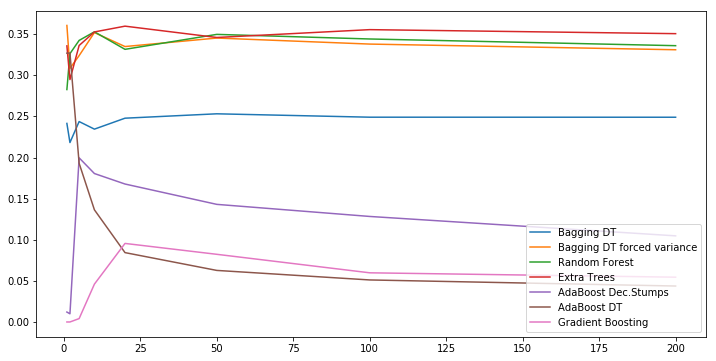

In [18]:
import  matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot([1,2,5,10,20,50,100,200],lb,label="Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],lb2,label="Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label="Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label="Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lboo,label="AdaBoost Dec.Stumps")
plt.plot([1,2,5,10,20,50,100,200],lboodt,label="AdaBoost DT")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label="Gradient Boosting")
plt.legend(loc='lower right')
plt.show()

## Feature Selection with Forests of trees

In [9]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,min_samples_split=13, min_impurity_split=0.9, class_weight='balanced', criterion='entropy')
clf = clf.fit(Xn_learn, y_learn)
print(clf.feature_importances_) 

[2.98520422e-02 1.48686986e-02 3.27405183e-02 1.56208736e-02
 1.95178296e-01 4.86995688e-02 5.44627341e-02 1.94640932e-01
 1.33998377e-01 3.40430787e-03 4.94852057e-03 1.74937755e-03
 1.29542523e-03 1.92689248e-03 3.00635210e-03 1.49963333e-03
 2.75975399e-03 3.05321663e-03 2.24239161e-03 9.89940860e-04
 3.19341494e-04 2.37691934e-03 3.22326575e-03 3.71044347e-03
 3.86940183e-04 2.01399170e-03 2.00138766e-03 3.22625794e-03
 2.44973278e-03 5.32830641e-05 2.30633059e-03 3.11347543e-03
 1.54768018e-03 9.78090704e-03 8.46963515e-03 0.00000000e+00
 2.98293083e-03 7.53582552e-04 2.70378327e-03 2.57399673e-03
 8.70243196e-04 2.13053451e-03 1.59569201e-02 1.53569678e-02
 5.05812535e-03 8.59205568e-04 1.35193308e-04 3.96334698e-04
 2.92156664e-03 9.14321138e-03 1.16487612e-02 6.24465950e-04
 6.17764691e-03 8.41344306e-04 3.68136781e-03 3.74742492e-03
 3.59761885e-03 2.70205004e-03 3.00450894e-03 2.56995221e-03
 1.91534703e-02 2.66014282e-02 2.81335974e-02 3.37563213e-02]


In [10]:
from sklearn.feature_selection import SelectFromModel
#threshold should be the same as knn?
model = SelectFromModel(clf, prefit=True, threshold=0.05)
X_new = model.transform(Xn_learn)
print(X_new.shape)

print(np.mean(cross_val_score(KNeighborsClassifier(p = 3, n_neighbors= 29, weights= 'uniform'), X=Xn_learn, y=y_learn, cv=cv, scoring=f_scorer,n_jobs=4)))
print(np.mean(cross_val_score(KNeighborsClassifier(p = 3, n_neighbors= 29, weights= 'uniform'), X=X_new, y=y_learn, cv=cv, scoring=f_scorer,n_jobs=4)))

(28832, 4)
0.17732878143994102
0.023304404730164503


## Final test with extra trees

In [14]:
#Maybe predict threshold?
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
ex = ExtraTreesClassifier(n_estimators=100,min_samples_split=13, min_impurity_split=0.9, class_weight='balanced', criterion='entropy')
ex.fit(Xn_learn,y_learn)
print("learn")
y_pred = ex.predict(Xn_learn)
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_learn, y_pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))
print("\nReport metrics: ")
print(metrics.classification_report(y_learn, y_pred))
print("test")
y_pred = ex.predict(Xn_test)
print("Confusion Matrix: ")
print(pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['yes', 'no']),
                   index=['true:yes', 'true:no'], columns=['pred:yes', 'pred:no']))
print("\nReport metrics: ")
print(metrics.classification_report(y_test, y_pred))

learn
Confusion Matrix: 
          pred:yes  pred:no
true:yes      2251      997
true:no       3719    21865

Report metrics: 
              precision    recall  f1-score   support

          no       0.96      0.85      0.90     25584
         yes       0.38      0.69      0.49      3248

   micro avg       0.84      0.84      0.84     28832
   macro avg       0.67      0.77      0.70     28832
weighted avg       0.89      0.84      0.86     28832

test
Confusion Matrix: 
          pred:yes  pred:no
true:yes       906      486
true:no       1679     9285

Report metrics: 
              precision    recall  f1-score   support

          no       0.95      0.85      0.90     10964
         yes       0.35      0.65      0.46      1392

   micro avg       0.82      0.82      0.82     12356
   macro avg       0.65      0.75      0.68     12356
weighted avg       0.88      0.82      0.85     12356

